# SHAP Tutorial

<br>
Course sections:
<ol>
<li> SHAP values
<li> SHAP aggregations
    <ol>
    <li> Force plots
    <li> Mean SHAP
    <li> Beeswarm
    <li> Violin
    <li> Heatmap
    <li> Dependence
    </ol>
<li> Custom SHAP plots
<li> Binary and mutliclass target variables 
<li> SHAP interaction values
<li> Categorical features
</ol>
<br>
<b>Dataset:</b> https://archive.ics.uci.edu/ml/datasets/Abalone


In [1]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore")

# Dataset


## Dataset: Abalone

O dataset **Abalone** é um clássico conjunto de dados utilizado em tarefas de regressão e classificação. Ele contém informações sobre **moluscos marinhos da espécie *Haliotis*, comumente conhecidos como abalone**, e seu objetivo principal é prever a **idade do animal** com base em características físicas.

A idade dos abalones não é medida diretamente; em vez disso, é estimada contando os anéis de crescimento na concha. Como isso normalmente exigiria cortar o animal, este conjunto de dados propõe o uso de variáveis físicas para prever esse número de anéis.

### Contexto biológico
- O abalone é um molusco com concha em espiral e corpo mole.
- Sua idade é estimada como:  
  **Idade = Número de anéis + 1.5**
- Esse valor de +1.5 anos representa uma média aproximada do tempo necessário para que os anéis comecem a se formar após o nascimento.

---

## Atributos do dataset

| Feature           | Tipo      | Descrição |
|-------------------|-----------|-----------|
| `Sex`             | Categórica (`'M'`, `'F'`, `'I'`) | Sexo do abalone: Masculino (M), Feminino (F) ou Indeterminado (I) (quando jovem demais para identificar o sexo). |
| `Length`          | Numérica contínua | Comprimento (em mm) do abalone — medido em linha reta, excluindo a concha. |
| `Diameter`        | Numérica contínua | Diâmetro (em mm) — perpendicular ao comprimento. |
| `Height`          | Numérica contínua | Altura (em mm) — com a concha. |
| `WholeWeight`     | Numérica contínua | Peso total (em gramas) do abalone (incluindo a concha). |
| `ShuckedWeight`   | Numérica contínua | Peso da carne retirada (comestível). |
| `VisceraWeight`   | Numérica contínua | Peso das vísceras (órgãos internos). |
| `ShellWeight`     | Numérica contínua | Peso da concha seca. |
| `Rings`           | Numérica discreta | **Variável alvo**. Representa o número de anéis de crescimento. A idade final é dada por `Rings + 1.5`. |

---

### Tarefa típica com este dataset

O dataset pode ser usado tanto para:
- **Regressão**: prever diretamente o número de anéis (ou idade).
- **Classificação**: categorizar em faixas etárias (ex: jovem, adulto, idoso).

---

Fonte: [UCI Machine Learning Repository - Abalone Dataset](https://archive.ics.uci.edu/ml/datasets/Abalone)


In [2]:
# import dataset
data = pd.read_csv(
    "data/abalone.data",
    names=[
        "sex",
        "length",
        "diameter",
        "height",
        "whole weight",
        "shucked weight",
        "viscera weight",
        "shell weight",
        "rings",
    ],
)

print(len(data))
data.head()

4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Text(0.5, 0, 'whole weight')

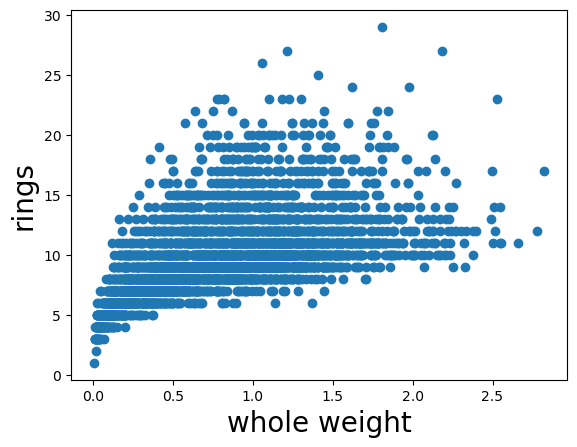

In [3]:
# plot 1: whole weight
plt.scatter(data["whole weight"], data["rings"])
plt.ylabel("rings", size=20)
plt.xlabel("whole weight", size=20)

Text(0.5, 0, 'sex')

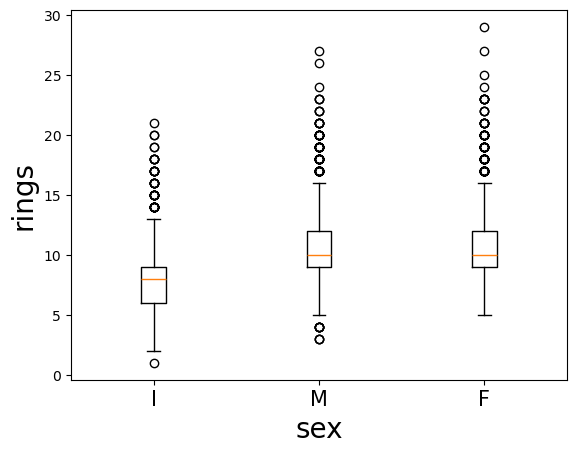

In [4]:
# plot 2: sex
plt.boxplot(data[data.sex == "I"]["rings"], positions=[1])
plt.boxplot(data[data.sex == "M"]["rings"], positions=[2])
plt.boxplot(data[data.sex == "F"]["rings"], positions=[3])

plt.xticks(ticks=[1, 2, 3], labels=["I", "M", "F"], size=15)
plt.ylabel("rings", size=20)
plt.xlabel("sex", size=20)

<Axes: >

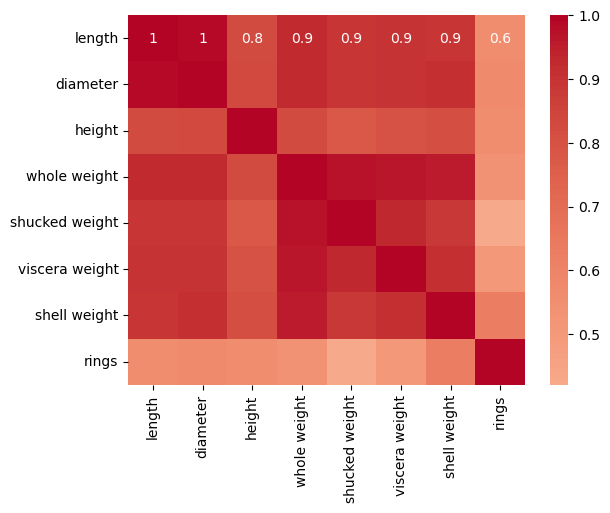

In [5]:
# plot 3: Correlation heatmap
cont = [
    "length",
    "diameter",
    "height",
    "whole weight",
    "shucked weight",
    "viscera weight",
    "shell weight",
    "rings",
]
corr_matrix = pd.DataFrame(data[cont], columns=cont).corr()

sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".1g")

# Feature Engineering


In [6]:
y = data["rings"]

# drop diameter and whole weight
X = data[["sex", "length", "height", "shucked weight", "viscera weight", "shell weight"]]

In [7]:
# create dummy variables
X["sex.M"] = [1 if s == "M" else 0 for s in X["sex"]]
X["sex.F"] = [1 if s == "F" else 0 for s in X["sex"]]
X["sex.I"] = [1 if s == "I" else 0 for s in X["sex"]]
X = X.drop("sex", axis=1)

X.head()

,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


In [8]:
features = X.copy()
features['y'] = y

features.head()

,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I,y
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0,15
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0,7
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0,9
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0,10
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1,7


# Modelling


In [9]:
# train model
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

Text(0.5, 0, 'Actual')

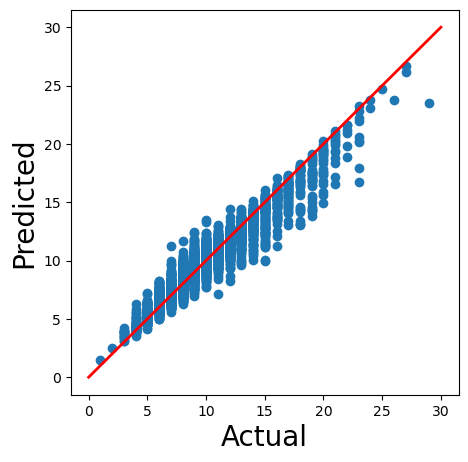

In [10]:
# get predictions
y_pred = model.predict(X)

# model evaluation
plt.figure(figsize=(5, 5))

plt.scatter(y, y_pred)
plt.plot([0, 30], [0, 30], color="r", linestyle="-", linewidth=2)

plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)

# 1) Standard SHAP values


In [11]:
# get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# shap_values = explainer(X[0:100])

In [12]:
np.shape(shap_values.values)

(4177, 8)

## Waterfall plot


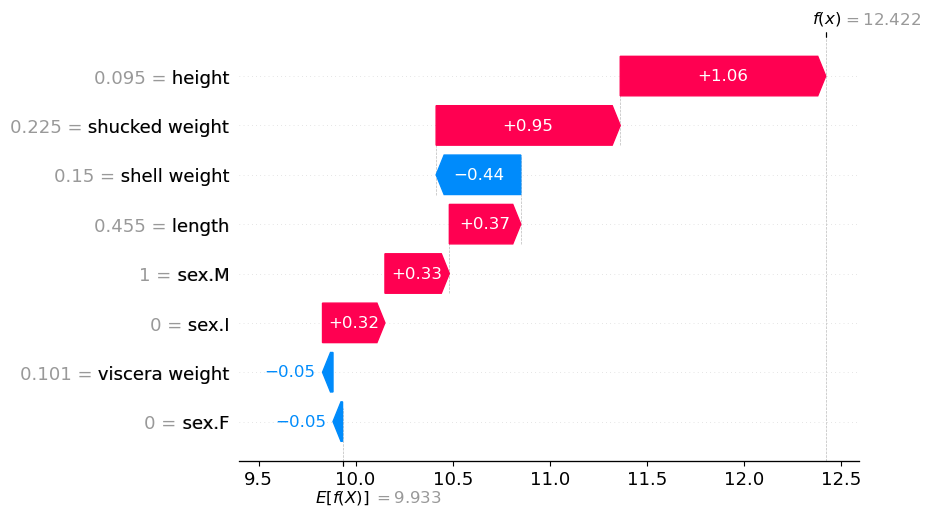

In [13]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

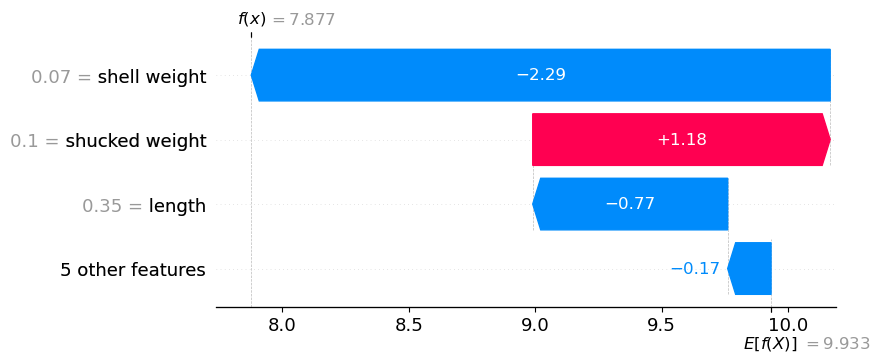

In [14]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[1], max_display=4)

# 2) SHAP aggregations


## Force plot


In [15]:
# force plot
shap.plots.force(shap_values[0])

## Stacked force plot


In [16]:
# stacked force plot
shap.plots.force(shap_values[0:100])

## Absolute Mean SHAP


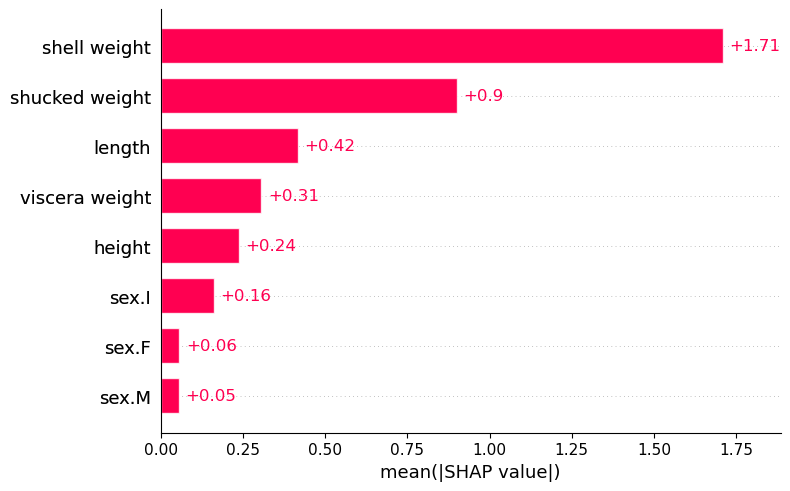

In [17]:
# mean SHAP
shap.plots.bar(shap_values)

## Beeswarm plot


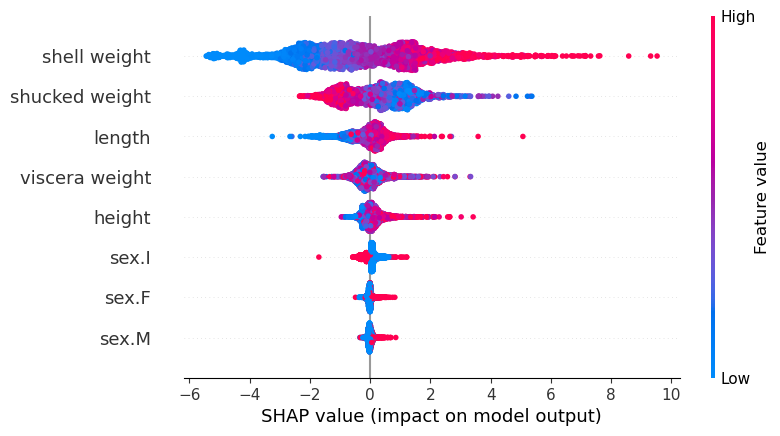

In [18]:
# beeswarm plot
shap.plots.beeswarm(shap_values)

## Violin plot


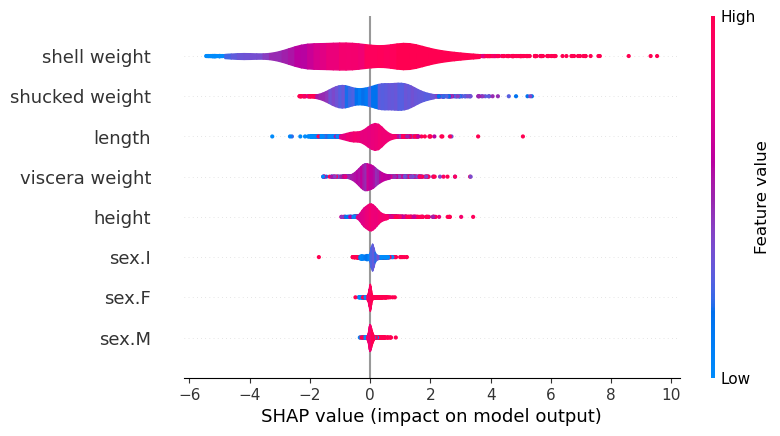

In [19]:
# violin plot
shap.plots.violin(shap_values)

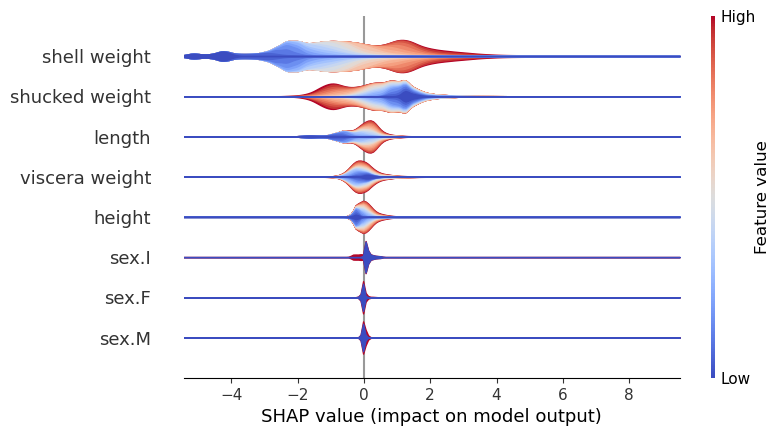

In [20]:
# layered violin plot
shap.plots.violin(shap_values, plot_type="layered_violin")

## Heamap


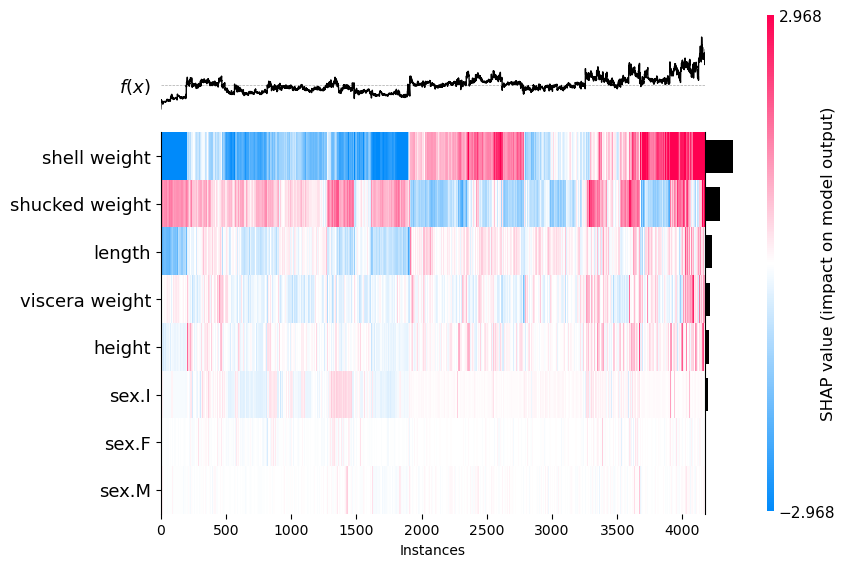

<Axes: xlabel='Instances'>

In [21]:
# heatmap
shap.plots.heatmap(shap_values)

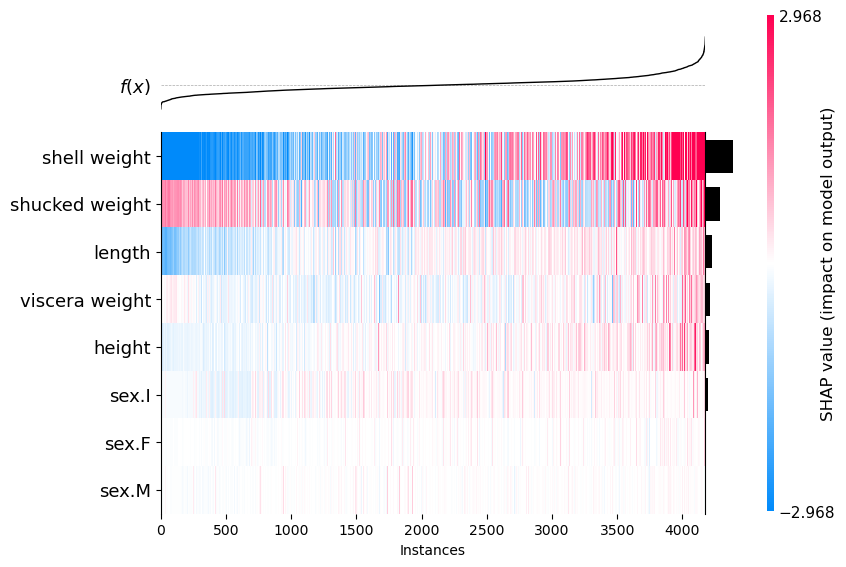

<Axes: xlabel='Instances'>

In [22]:
# order by predictions
order = np.argsort(y_pred)
shap.plots.heatmap(shap_values, instance_order=order)

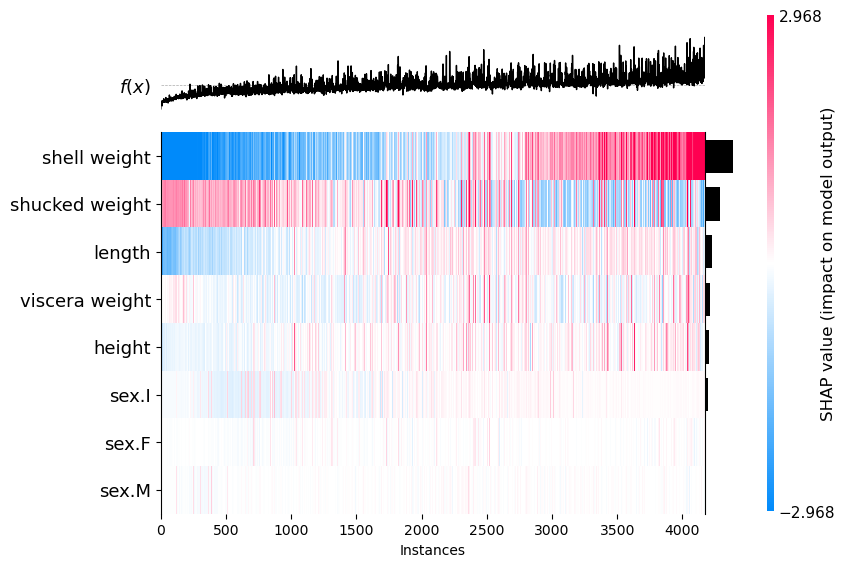

<Axes: xlabel='Instances'>

In [23]:
# order by shell weight value
order = np.argsort(data["shell weight"])
shap.plots.heatmap(shap_values, instance_order=order)

## Dependence plots


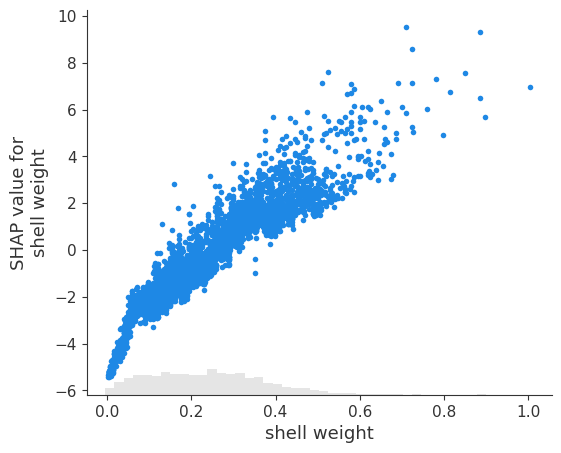

In [24]:
# plot 1: shell weight
shap.plots.scatter(shap_values[:, "shell weight"])

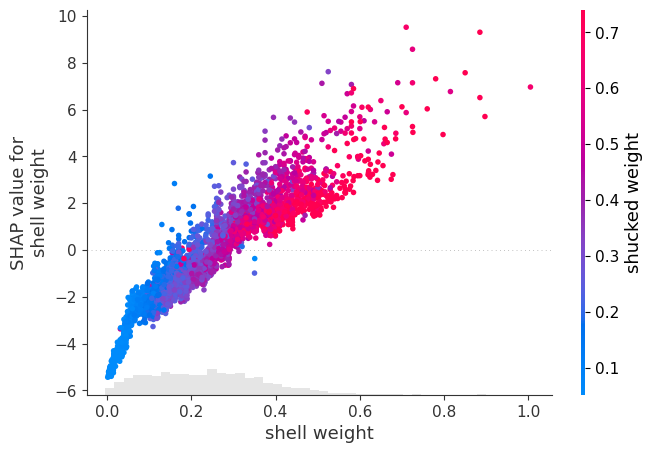

In [25]:
shap.plots.scatter(
    shap_values[:, "shell weight"], color=shap_values[:, "shucked weight"]
)

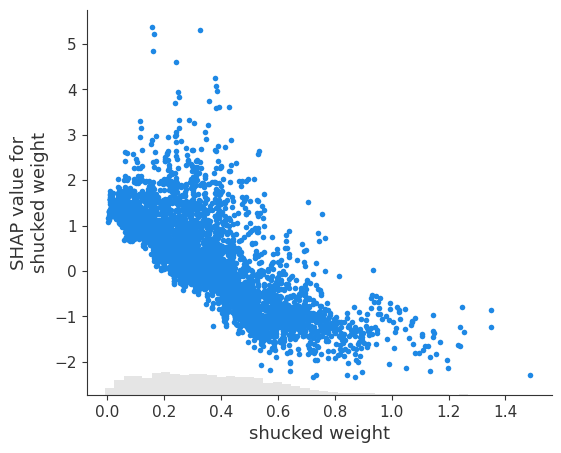

In [26]:
# plot 2: shucked weight
shap.plots.scatter(shap_values[:, "shucked weight"])

# 3) Custom Plots


In [27]:
# output SHAP object
shap_values

.values =
array([[ 0.36806285,  1.0587054 ,  0.94834965, ...,  0.3316413 ,
        -0.04919233,  0.3216473 ],
       [-0.7708986 , -0.21779695,  1.176285  , ...,  0.05278974,
        -0.0395156 ,  0.49588168],
       [ 0.15351889, -0.02277692,  0.47050092, ...,  0.04105941,
         0.04848656,  0.12317639],
       ...,
       [ 0.14958209,  0.32025054, -1.4478747 , ...,  0.04284297,
         0.01527823,  0.02549139],
       [-0.04009023, -0.09120232, -0.919325  , ...,  0.05648781,
         0.05737196,  0.09682811],
       [ 0.61490464,  0.388789  , -0.55129325, ...,  0.05122245,
         0.00867648,  0.07278913]], dtype=float32)

.base_values =
array([9.93266, 9.93266, 9.93266, ..., 9.93266, 9.93266, 9.93266],
      dtype=float32)

.data =
array([[0.455 , 0.095 , 0.2245, ..., 1.    , 0.    , 0.    ],
       [0.35  , 0.09  , 0.0995, ..., 1.    , 0.    , 0.    ],
       [0.53  , 0.135 , 0.2565, ..., 0.    , 1.    , 0.    ],
       ...,
       [0.6   , 0.205 , 0.5255, ..., 1.    , 0.    

In [28]:
np.shape(shap_values.values)

(4177, 8)

<Axes: >

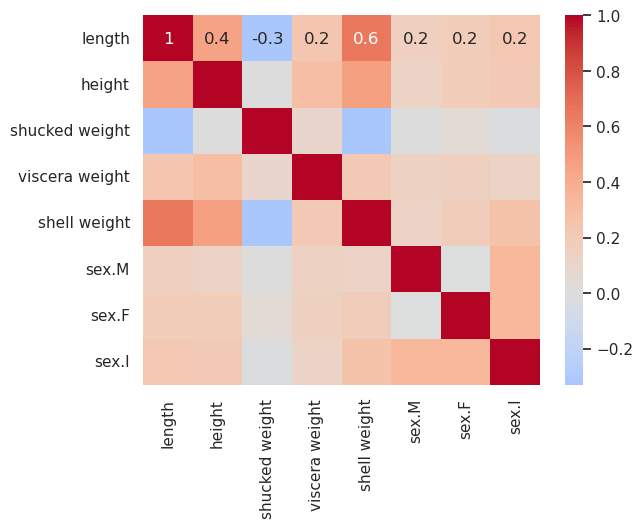

In [29]:
# SHAP correlation plot
corr_matrix = pd.DataFrame(shap_values.values, columns=X.columns).corr()

sns.set(font_scale=1)
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".1g")

# 4) Binary and categorical target variables


### Binary target variable


In [33]:
# binary target varibale
y_bin = [1 if y_ > 10 else 0 for y_ in y]

In [34]:
# train model
model_bin = xgb.XGBClassifier(objective="binary:logistic")
model_bin.fit(X, y_bin)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [35]:
# get shap values
explainer = shap.Explainer(model_bin)
shap_values_bin = explainer(X)

print(shap_values_bin.shape)

(4177, 8)


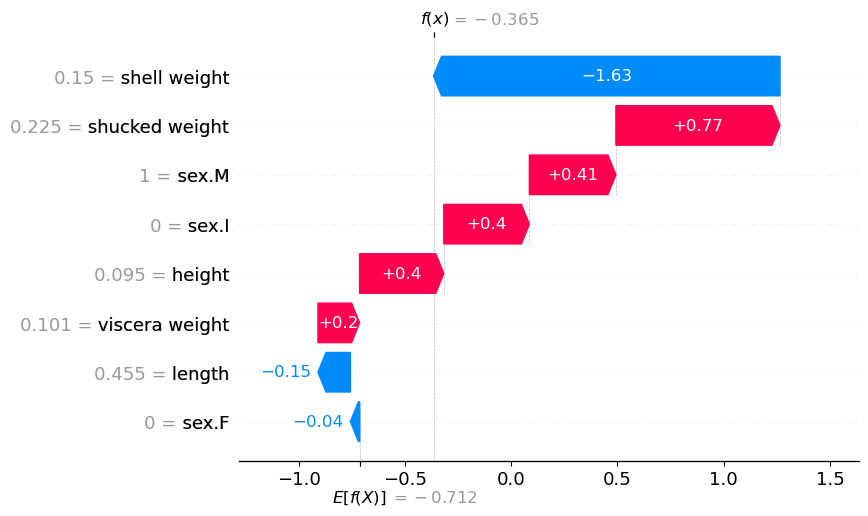

In [36]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values_bin[0])

In [37]:
# waterfall plot for first observation
shap.plots.force(shap_values_bin[0], link="logit")

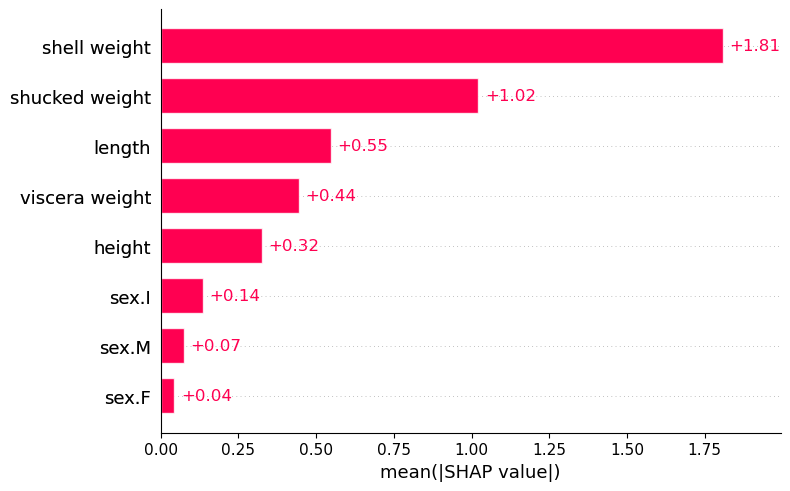

In [38]:
# waterfall plot for first observation
shap.plots.bar(shap_values_bin)